# CNN + DropConnect example

In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import numpy as np
import jax
import jax.numpy as jnp

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import crayflow as flow
from craynn import *

SEED = 1110002223

rng = jax.random.PRNGKey(SEED)

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Data

In [2]:
dataflow = flow.dataflow(
    mnist_paths=flow.instances.mnist.download_mnist('MNIST'),
    mnist=flow.instances.mnist.read_mnist,
)

data_train, labels_train, data_test, labels_test = \
    dataflow['mnist']['data_train', 'labels_train', 'data_test', 'labels_test']()

In [3]:
data_train, labels_train, data_val, labels_val = flow.data.split(0.95, seed=SEED + 1)(data_train, labels_train)

X_train, y_train = jnp.array(data_train, dtype=jnp.float32), jnp.array(labels_train, dtype=jnp.float32)
X_val, y_val = jnp.array(data_val, dtype=jnp.float32), jnp.array(labels_val, dtype=jnp.float32)
X_test, y_test = jnp.array(data_test, dtype=jnp.float32), jnp.array(labels_test, dtype=jnp.float32)

dataset_train = array_dataset(X_train, y_train)
dataset_val = array_dataset(X_val, y_val)
dataset_test = array_dataset(X_test, y_test)

## Network definition

In [4]:
net = network((None, 1, 28, 28))(
    conv(64, W=drop_connect(p=0.2)),
    conv(96, W=drop_connect(p=0.2)),
    max_pool(),
    
    conv(128, W=drop_connect(p=0.2)),
    conv(192, W=drop_connect(p=0.2)),
    
    max_pool(),
    conv(256, W=drop_connect(p=0.2)),
    
    max_pool(),
    
    flatten(),
    dense(10, activation=linear()),
)

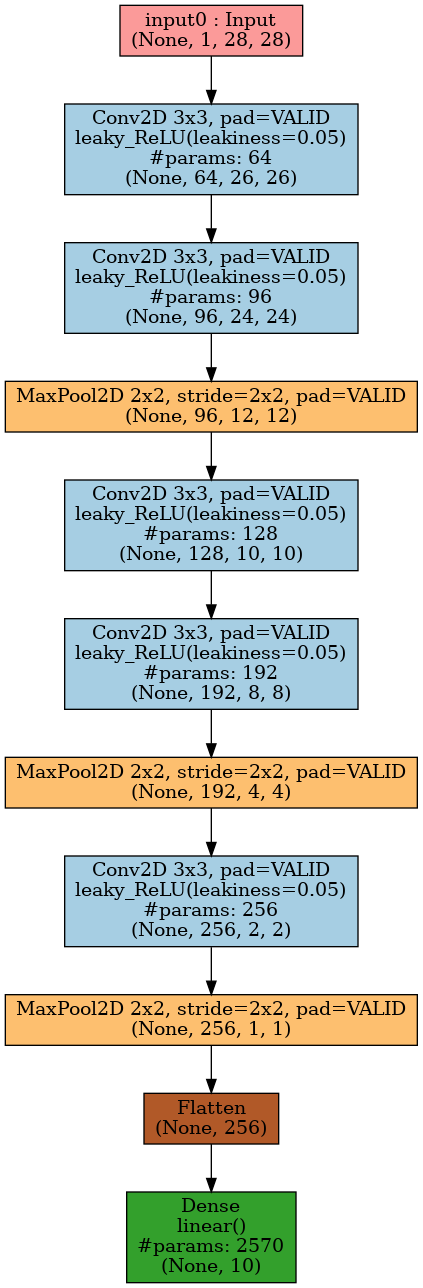

In [5]:
viz.draw_to_notebook(net)

## Parameter initialization and normalization

In [6]:
key_init, rng = jax.random.split(rng, num=2)
initial_params = train.initialize_parameters(key_init, net)

key_batch, rng = jax.random.split(rng, num=2)
X_sample, _ = dataset_train.batch(key_batch, size=32)

initial_params = train.normalize_weights(net, (X_sample, ), initial_params, progress=tqdm)

normalization:   0%|          | 0/11 [00:00<?, ?it/s]

## Training

In [7]:
from crayopt import adam, iterate

optimizer = adam(learning_rate=1e-3, )

batch_size = 16

def loss(params, X_batch, y_batch, rng):
    predictions = net(X_batch, params, rng=rng)
    cross_entropy = jnp.mean(
        objectives.logit_categorical_crossentropy(y_batch, predictions)
    )
    
    regularization = 1e-4 * objectives.l2_reg(params(weights=True))    
    
    return cross_entropy + regularization

@jax.jit
def step(rng, params, state, X, y):
    rng, key_sampling, key_net = jax.random.split(rng, num=3)
    
    indx = jax.random.randint(key_sampling, minval=0, maxval=X.shape[0], shape=(batch_size, ))
    X_batch, y_batch = X[indx], y[indx]
    
    l, grad = jax.value_and_grad(loss, argnums=0)(params, X_batch, y_batch, key_net)
    params_updated, state_updated = optimizer(params, grad, state)
    return rng, params_updated, state_updated, l

def validation_loss(params):
    pred, = dataset_val.eval(lambda x, _: net(x, params), batch_size=32, jit=True)
    return jnp.mean(objectives.logit_categorical_crossentropy(y_val, pred))

In [8]:
n_epoches = 256
n_iterations = X_train.shape[0] // batch_size

_, params, _, losses, validation_losses = iterate(
    lambda rng, params, state: step(rng, params, state, X_train, y_train),
    n_epoches, n_iterations, progress=tqdm
).validate(validation_loss)(
    rng, initial_params, optimizer.initial_state(initial_params)
)

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/3562 [00:00<?, ?it/s]

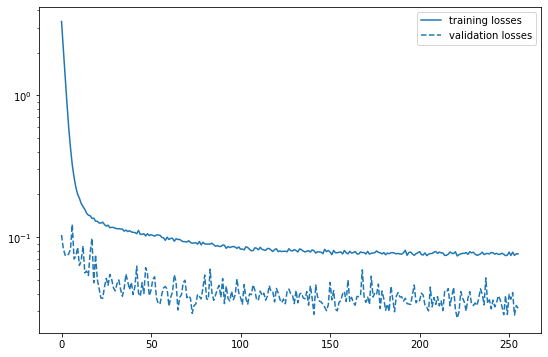

In [9]:
plt.figure(figsize=(9, 6))

plt.plot(np.mean(losses, axis=1), color=plt.cm.tab10(0), label='training losses')
plt.plot(validation_losses, color=plt.cm.tab10(0), linestyle='--', label='validation losses')

plt.yscale('log')
plt.legend()
plt.show()

## Test

In [10]:
predictions_train, = dataset_train.eval(lambda x, _: net(x, params), batch_size=128, jit=True)
predictions_test, = dataset_test.eval(lambda x, _: net(x, params), batch_size=128, jit=True)

In [11]:
predicted_classes_train = np.argmax(predictions_train, axis=1)
predicted_classes_test = np.argmax(predictions_test, axis=1)

In [12]:
accuracy_train = np.mean(
    predicted_classes_train == np.argmax(y_train, axis=1)
)

accuracy_test = np.mean(
    predicted_classes_test == np.argmax(y_test, axis=1)
)

print('Accuracy: %.3lf (%.3lf)' % (accuracy_test, accuracy_train))

Accuracy: 0.991 (0.995)


In [13]:
indx_wrong, = jnp.where(predicted_classes_test != np.argmax(y_test, axis=1))

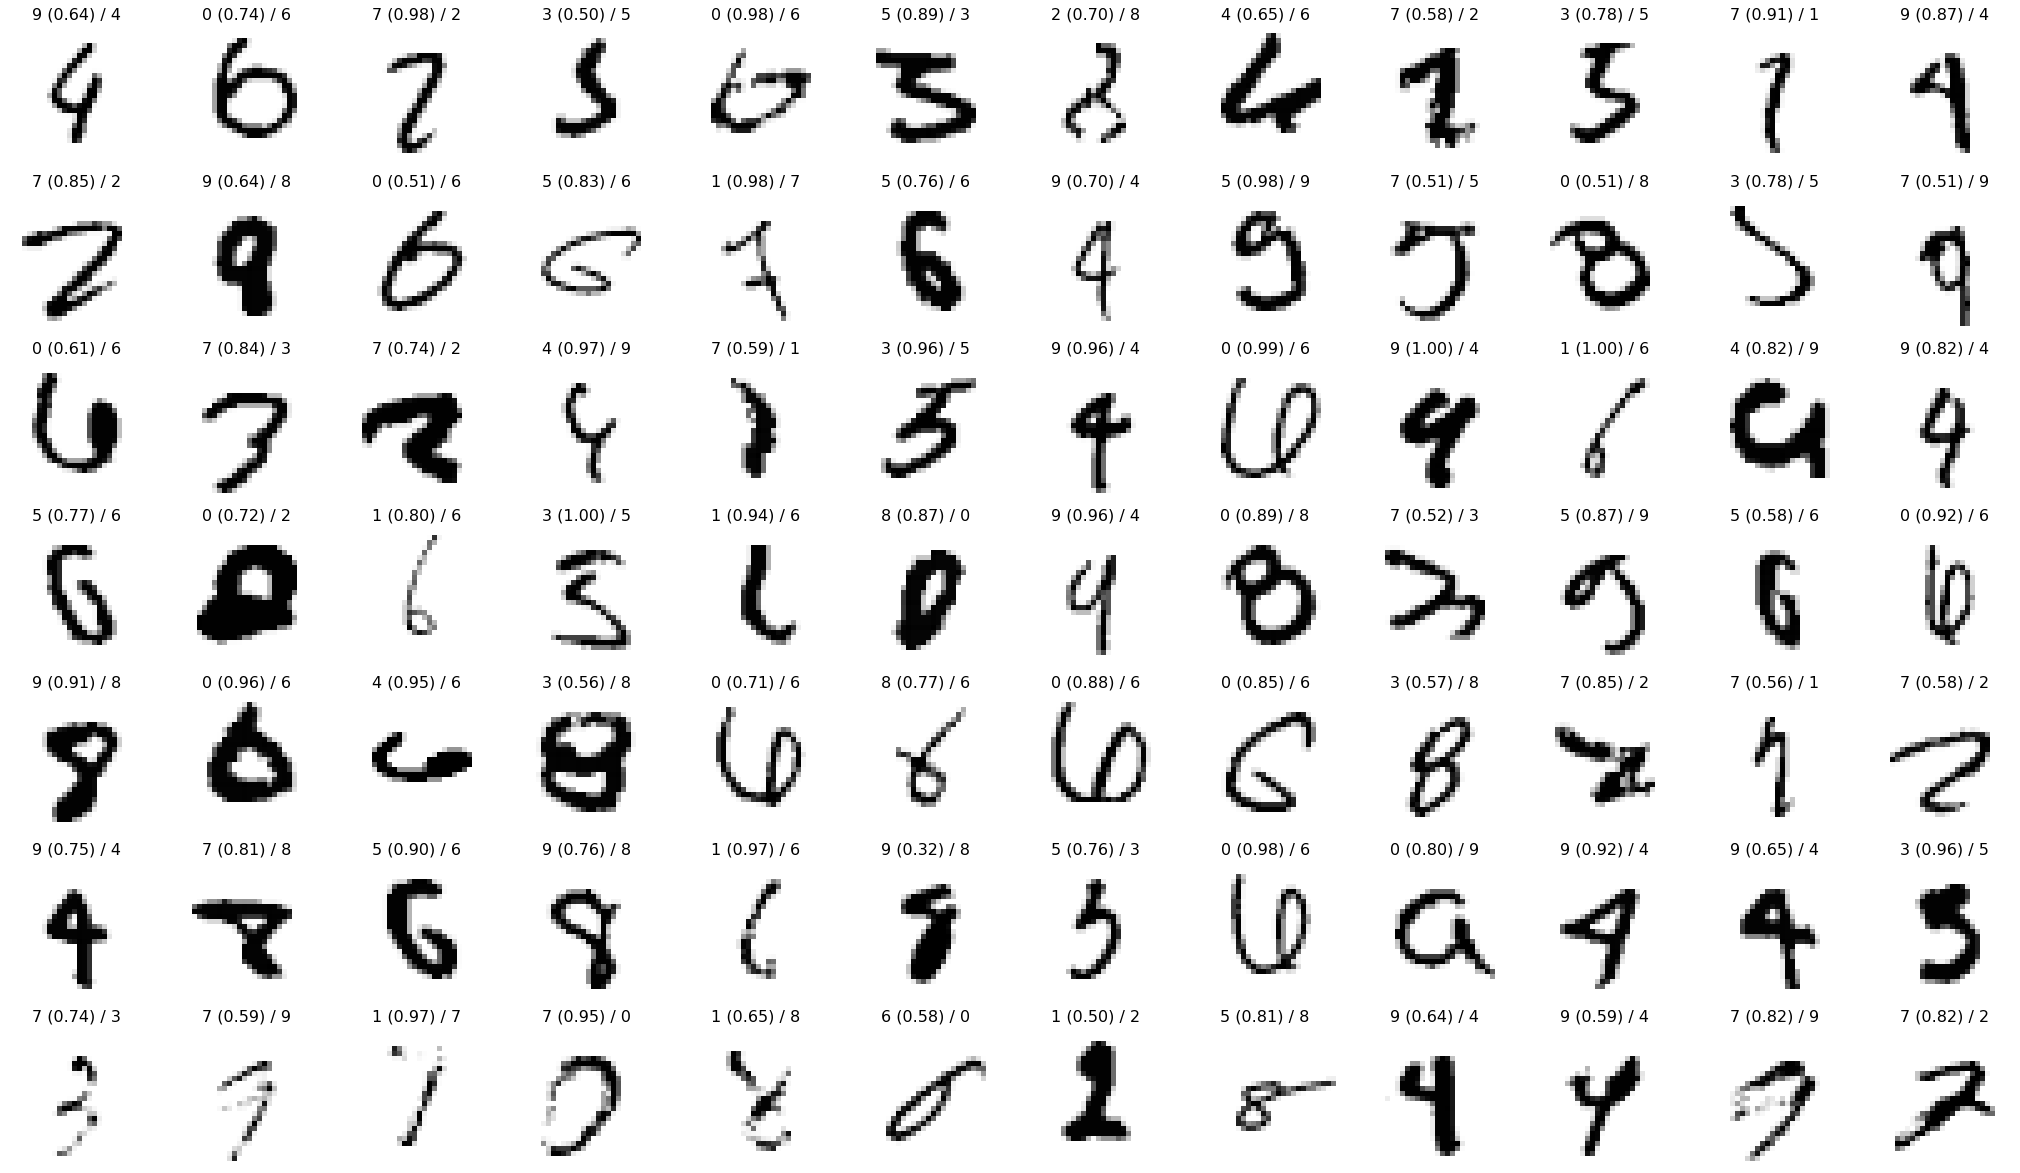

In [14]:
ncols = min(12, indx_wrong.shape[0])
nrows = max(1, indx_wrong.shape[0]) // ncols
nrows = min(12, nrows)

fig = plt.figure(figsize=(3 * ncols, 3 * nrows))
axes = fig.subplots(nrows, ncols)

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        axe = axes[i, j]
        indx = indx_wrong[k]
        axe.imshow(X_test[indx, 0], cmap=plt.cm.Greys)
        axe.axis('off')
        axe.set_title(
            '%d (%.2lf) / %d' % (
                predicted_classes_test[indx],
                jax.nn.softmax(predictions_test[indx])[predicted_classes_test[indx]],
                np.argmax(y_test[indx])
            ),
            fontsize=16
        )